In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load withinFile_df, withinRepo_df and acrossRepo_df from pickle files (../parsers/parsed/)
withinFile_df = pd.read_pickle("../../parsers/parsed/withinFile.pkl")
buckets_df = pd.read_pickle("../../parsers/parsed/buckets_df.pkl")

In [3]:
withinFile_df = pd.merge(withinFile_df, buckets_df[['classid', 'nlines']], left_on='bucketId', right_on='classid', how='left')
withinFile_df = withinFile_df.drop_duplicates().reset_index(drop=True)
withinFile_df = withinFile_df.drop(columns=['classid'])

In [4]:
withinFile_df

,bucketId,similarity,fileName,userName,repoName,sameFileApperances,clonePairCount,nlines
0,3,71,test.py,raheelqader,torchtext_lite,11,55.0,14
1,4,84,test.py,raheelqader,torchtext_lite,2,1.0,25
2,10,90,hubconf.py,rasbt,ord-torchhub,4,6.0,30
3,11,70,15_ResNet_from_scratch.py,muratonuryildirim,PyTorch_Notes,3,3.0,14
4,11,70,Autoencoder.py,grassknoted,PyTorch-Autoencoder,2,1.0,14
...,...,...,...,...,...,...,...,...
1085,3323,75,unet_modules.py,mcgoughlin,PyTorch-UNet,3,3.0,12
1086,3324,80,load_data.py,jiaxiang-cheng,PyTorch-CNN-for-RUL-Prediction,4,6.0,19
1087,3325,93,main.py,VikHerr,DeepVis-PredDiff-PyTorch,3,3.0,15
1088,3326,77,ProgGAN.py,ConnorJL,ProgGAN-PyTorch,2,1.0,21


In [5]:
# make above a generalized function
def makeBins(df, column, bins = [5, 10, 15, 20, 25, 30, 50, 10000], labels = ['5-10', '11-15', '16-20', '21-25', '26-30', '31-50', '50+']):
    df["nlinesBins"] = pd.cut(df[column], bins=bins, labels=labels)
    return df
def makeSimilarityTypes(df, column, threshold):
    df[column + 'Type'] = np.where(df[column] > threshold, "Type 1/2", "Type 3")
    return df




In [6]:
withinFile_df = makeBins(withinFile_df, 'nlines')
withinFile_df = makeSimilarityTypes(withinFile_df, 'similarity', 95)

In [7]:
# bar plot for withinFile_df
# segment the bars by similarityType and nlineBins, y axis is clonePairCount
def plotClonePairByLinesAndSimilarity(df): 
    sns.set(style="whitegrid")
    g = sns.boxplot(x="nlinesBins", y="clonePairCount", hue="similarityType", data=df, palette="muted")
    medians = withinFile_df.groupby(['nlinesBins', 'similarityType'])['clonePairCount'].median().values 
    nobs = withinFile_df['nlinesBins'].value_counts().values
    nobs = [str(x) for x in nobs.tolist()]
    pos = range(len(nobs))
    for tick,label in zip(pos,g.get_xticklabels()):
        g.text(pos[tick], medians[tick] + 0.03, nobs[tick], horizontalalignment='center', size='x-small', color='b', weight='semibold')
    
    g.set_ylabel("Clone Pair Count")
    g.set_xlabel("Number of Lines")
    
    plt.title("WithinFile Clone Pair Count by Number of Lines and Similarity Type")
    plt.show()


In [10]:
# let's group by nlinesBins and similarityType and get the total clonePairCount and sameFileAppearances
grouped = withinFile_df.groupby(['nlinesBins', 'similarityType']).agg({'clonePairCount': 'sum', 'sameFileApperances': 'mean'}).reset_index()

/tmp/ipykernel_10370/3364954983.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = withinFile_df.groupby(['nlinesBins', 'similarityType']).agg({'clonePairCount': 'sum', 'sameFileApperances': 'mean'}).reset_index()


In [11]:
grouped

,nlinesBins,similarityType,clonePairCount,sameFileApperances
0,5-10,Type 1/2,49.0,2.434783
1,5-10,Type 3,67.0,2.411765
2,11-15,Type 1/2,84.0,2.210526
3,11-15,Type 3,833.0,2.360097
4,16-20,Type 1/2,72.0,2.346154
5,16-20,Type 3,356.0,2.308989
6,21-25,Type 1/2,10.0,2.000000
7,21-25,Type 3,158.0,2.219048
8,26-30,Type 1/2,29.0,2.266667
9,26-30,Type 3,152.0,2.369231


In [12]:
def calculate_clone_percentage(df, nlines_bins_col='nlinesBins', similarity_type_col='similarityType', clone_pair_count_col='clonePairCount'):
    """
    Calculates the percentage of clone pairs for each nlines bin and similarity type.

    Parameters:
    - df: DataFrame containing the clone data.
    - nlines_bins_col: Column name for the nlines bins.
    - similarity_type_col: Column name for the similarity type.
    - clone_pair_count_col: Column name for the count of clone pairs.

    Returns:
    - A DataFrame with the original columns plus a 'percentage' column representing
      the percentage of clone pairs for each nlines bin and similarity type.
    """

    # Group by nlinesBins and similarityType, then sum up clonePairCount
    grouped_df = df.groupby([nlines_bins_col, similarity_type_col]).agg({clone_pair_count_col: 'sum'}).reset_index()

    # Calculate the total clone counts per nlines bin
    total_clones_per_bin = df.groupby(nlines_bins_col)[clone_pair_count_col].sum().reset_index(name='totalCloneCount')

    # Merge to calculate percentages
    merged_df = pd.merge(grouped_df, total_clones_per_bin, on=nlines_bins_col)
    merged_df['percentage'] = (merged_df[clone_pair_count_col] / merged_df['totalCloneCount']) * 100

    # Select and return the desired columns
    result_df = merged_df[[nlines_bins_col, similarity_type_col, clone_pair_count_col, 'percentage']]
    result_df.sort_values(by=[similarity_type_col], inplace=True)
    return result_df


In [13]:
# get proportions of each nlinesBin by similarityType as percentages
withinFile_nlinesSim_df = calculate_clone_percentage(withinFile_df)

/tmp/ipykernel_10370/1586855920.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby([nlines_bins_col, similarity_type_col]).agg({clone_pair_count_col: 'sum'}).reset_index()
/tmp/ipykernel_10370/1586855920.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_clones_per_bin = df.groupby(nlines_bins_col)[clone_pair_count_col].sum().reset_index(name='totalCloneCount')
/tmp/ipykernel_10370/1586855920.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [14]:
withinFile_nlinesSim_df

,nlinesBins,similarityType,clonePairCount,percentage
0,5-10,Type 1/2,49.0,42.241379
2,11-15,Type 1/2,84.0,9.160305
4,16-20,Type 1/2,72.0,16.822430
6,21-25,Type 1/2,10.0,5.952381
8,26-30,Type 1/2,29.0,16.022099
10,31-50,Type 1/2,30.0,19.736842
12,50+,Type 1/2,11.0,7.236842
1,5-10,Type 3,67.0,57.758621
3,11-15,Type 3,833.0,90.839695
5,16-20,Type 3,356.0,83.177570


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_clone_pair_counts(df, x_col='nlinesBins', y_col='clonePairCount', hue_col='similarityType',
                           palette=None, fig_size=(15, 6), rotation=45, title="Clone Pair Counts by Number of Lines and Type"):
    """
    Plots a bar chart with annotations for clone pair counts.

    Parameters:
    - df: DataFrame containing the data to plot.
    - x_col: The name of the DataFrame column to use for the x-axis.
    - y_col: The name of the DataFrame column to use for the y-axis.
    - hue_col: The name of the DataFrame column to use for the hue.
    - palette: A dictionary mapping hue levels to matplotlib colors.
    - fig_size: Tuple specifying the figure size.
    - rotation: The rotation angle of the x-axis tick labels.
    - title: The title of the plot.
    """

    # Sort the DataFrame by the hue column and then by the x-axis column
    df.sort_values(by=[hue_col, x_col], inplace=True)

    # Set the plotting style
    sns.set(style="whitegrid")

    # Create the bar plot
    plt.figure(figsize=fig_size)
    ax = sns.barplot(x=x_col, y=y_col, hue=hue_col, data=df, palette=palette)

    # Set the plot title and labels
    ax.set_title(title)
    ax.set_ylabel(y_col)
    ax.set_xlabel(x_col)
    plt.xticks(rotation=rotation)
    plt.legend(title=hue_col)

    # Adding annotations for each bar
    for p, (index, row) in zip(ax.patches, df.iterrows()):
        annotation = f"{p.get_height():.0f} ({row.get('percentage', 0):.2f}%)"
        ax.annotate(annotation, (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', 
                    fontsize=8, color='black', xytext=(0, 5), textcoords='offset points')

    plt.show()

# Example usage:


/home/abeeto/miniconda3/envs/ldaTopicModel/lib/python3.12/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/abeeto/miniconda3/envs/ldaTopicModel/lib/python3.12/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


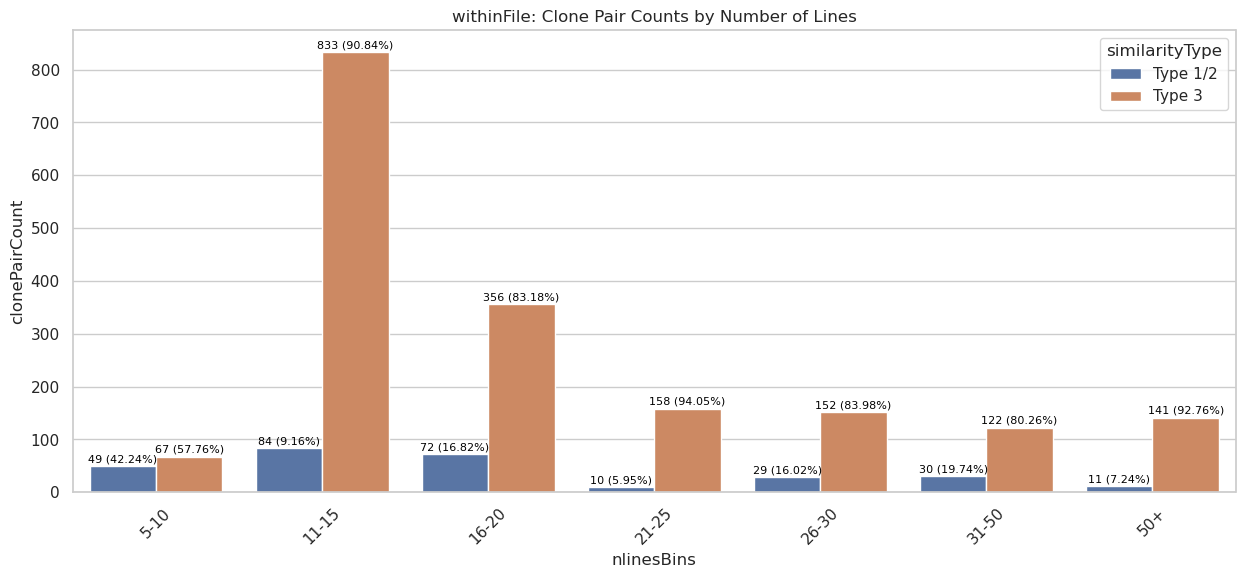

In [16]:
plot_clone_pair_counts(withinFile_nlinesSim_df, title="withinFile: Clone Pair Counts by Number of Lines")


In [17]:
withinRepo_df = pd.read_pickle("../../parsers/parsed/withinRepo.pkl")
withinRepo_df

,bucketId,userName,repoName,similarity,cloneFragments,clonePairs,clonePairCount
20,7,DetectionBLWX,FPN.pytorch,80,"[{'fileName': 'demo.py', 'startline': 21, 'end...","[(demo.py, test.py)]",1
21,7,DetectionBLWX,ssdetection,80,"[{'fileName': 'demo.py', 'startline': 19, 'end...","[(demo.py, test.py)]",1
40,11,BenjaminAm,PyTorch-Tutorial,70,"[{'fileName': 'untitled0.py', 'startline': 66,...","[(untitled0.py, Tutorial3CatsDogs.py), (untitl...",3
42,11,BoriaK,AutoEncoder_PyTorch,70,"[{'fileName': 'models.py', 'startline': 220, '...","[(models.py, models_from_Avi.py)]",1
44,11,CeasonCui,CNN_PyTorch,70,"[{'fileName': '_5_cnn_acc_check.py', 'startlin...","[(_5_cnn_acc_check.py, _4_cnn_fm.py), (_5_cnn_...",3
...,...,...,...,...,...,...,...
8186,3317,ptklx,learn_deep_from_torchvsion,87,"[{'fileName': 'train.py', 'startline': 182, 'e...","[(train.py, train_egg_dirty.py)]",1
8187,3318,ptklx,learn_deep_from_torchvsion,92,"[{'fileName': 'train.py', 'startline': 369, 'e...","[(train.py, train_egg_dirty.py)]",1
8189,3320,dreamplus1989,yolov3-plus_PyTorch,73,"[{'fileName': 'train_coco.py', 'startline': 76...","[(train_coco.py, train_voc.py)]",1
8190,3321,dreamplus1989,yolov3-plus_PyTorch,70,"[{'fileName': 'test_coco.py', 'startline': 63,...","[(test_coco.py, test_voc.py)]",1


In [18]:
withinRepo_nlinesSim_df = pd.merge(withinRepo_df[['bucketId', 'userName', 'repoName', 'clonePairCount']], buckets_df[['classid', 'similarity', 'nlines']], left_on='bucketId', right_on='classid', how='left').drop_duplicates().reset_index(drop=True)
withinRepo_nlinesSim_df.drop(columns=['classid'], inplace=True)
withinRepo_nlinesSim_df = makeBins(withinRepo_nlinesSim_df, 'nlines')
withinRepo_nlinesSim_df = makeSimilarityTypes(withinRepo_nlinesSim_df, 'similarity', 85)

In [20]:

withinRepo_nlinesSim_df = calculate_clone_percentage(withinRepo_nlinesSim_df)
withinRepo_nlinesSim_df

/tmp/ipykernel_10370/1586855920.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby([nlines_bins_col, similarity_type_col]).agg({clone_pair_count_col: 'sum'}).reset_index()
/tmp/ipykernel_10370/1586855920.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_clones_per_bin = df.groupby(nlines_bins_col)[clone_pair_count_col].sum().reset_index(name='totalCloneCount')
/tmp/ipykernel_10370/1586855920.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

,nlinesBins,similarityType,clonePairCount,percentage
0,5-10,Type 1/2,214,86.290323
2,11-15,Type 1/2,682,42.731830
4,16-20,Type 1/2,528,51.063830
6,21-25,Type 1/2,246,55.033557
8,26-30,Type 1/2,138,34.848485
10,31-50,Type 1/2,180,38.961039
12,50+,Type 1/2,117,27.272727
1,5-10,Type 3,34,13.709677
3,11-15,Type 3,914,57.268170
5,16-20,Type 3,506,48.936170


/home/abeeto/miniconda3/envs/ldaTopicModel/lib/python3.12/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/abeeto/miniconda3/envs/ldaTopicModel/lib/python3.12/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


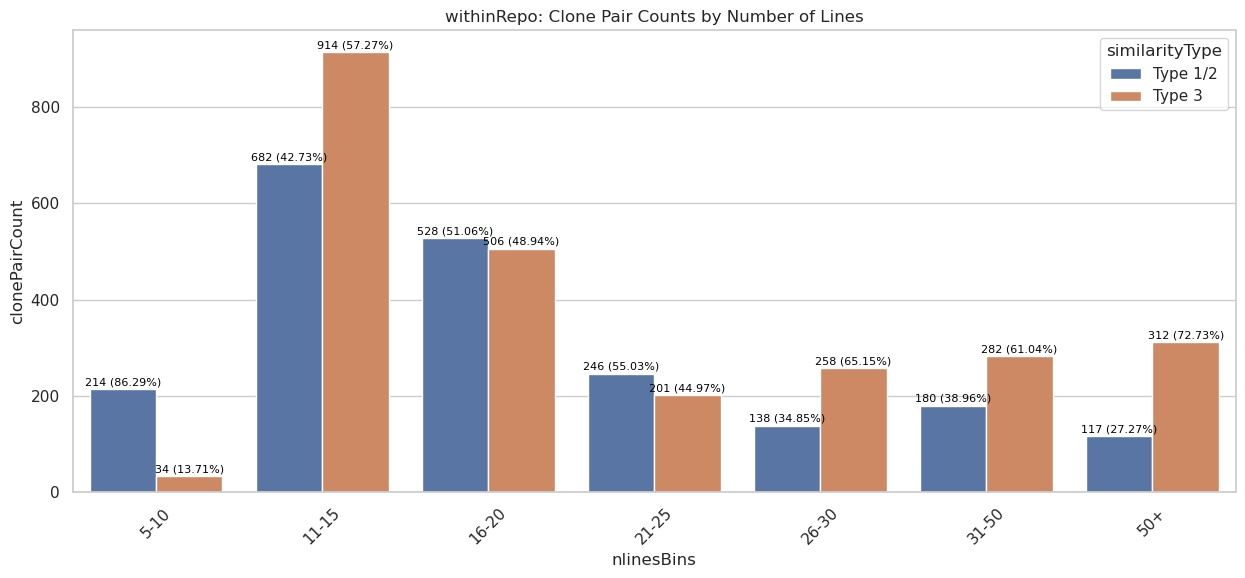

In [21]:
plot_clone_pair_counts(withinRepo_nlinesSim_df, title="withinRepo: Clone Pair Counts by Number of Lines")

In [22]:
acrossRepo_df = pd.read_pickle("../../parsers/parsed/acrossRepos_df.pkl")
acrossRepo_df

,bucketId,similarity,repoObjects,acrossRepoPairs,sameUser,acrossRepoPairsCount
0,1,74,"[{'repoName': 'Flask-PyTorch-Chatbot', 'userNa...","[({'repoName': 'Flask-PyTorch-Chatbot', 'userN...",False,1
1,2,70,"[{'repoName': 'NSRR-PyTorch', 'userName': 'IMA...","[({'repoName': 'NSRR-PyTorch', 'userName': 'IM...",False,66
4,5,81,[{'repoName': 'IMDB-Sentiment-Analysis-using-P...,[({'repoName': 'IMDB-Sentiment-Analysis-using-...,False,1
5,6,98,"[{'repoName': 'ssdetection', 'userName': 'Dete...","[({'repoName': 'ssdetection', 'userName': 'Det...",True,1
6,7,80,"[{'repoName': 'ssdetection', 'userName': 'Dete...","[({'repoName': 'ssdetection', 'userName': 'Det...",True,4
...,...,...,...,...,...,...
3140,3141,83,[{'repoName': 'FlowNet2-PyTorch-EasyToUse-Wrap...,[({'repoName': 'FlowNet2-PyTorch-EasyToUse-Wra...,False,1
3197,3198,70,"[{'repoName': 'ReID.PyTorch', 'userName': 'zhu...","[({'repoName': 'ReID.PyTorch', 'userName': 'zh...",False,1
3270,3271,78,"[{'repoName': 'SSE-PT-torch', 'userName': 'hsu...","[({'repoName': 'SSE-PT-torch', 'userName': 'hs...",False,1
3302,3303,100,"[{'repoName': 'Deep_Learning_PyTorch', 'userNa...","[({'repoName': 'Deep_Learning_PyTorch', 'userN...",False,1


In [23]:

acrossRepo_nlinesSim_df = pd.merge(acrossRepo_df[['bucketId', 'acrossRepoPairsCount']], buckets_df[['classid', 'similarity', 'nlines']], left_on='bucketId', right_on='classid', how='left').drop_duplicates().reset_index(drop=True)
acrossRepo_nlinesSim_df.drop(columns=['classid'], inplace=True)
acrossRepo_nlinesSim_df = makeBins(acrossRepo_nlinesSim_df, 'nlines')
acrossRepo_nlinesSim_df = makeSimilarityTypes(acrossRepo_nlinesSim_df, 'similarity', 85)

acrossRepo_nlinesSim_df = calculate_clone_percentage(acrossRepo_nlinesSim_df, clone_pair_count_col='acrossRepoPairsCount')
acrossRepo_nlinesSim_df

/tmp/ipykernel_10370/1586855920.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby([nlines_bins_col, similarity_type_col]).agg({clone_pair_count_col: 'sum'}).reset_index()
/tmp/ipykernel_10370/1586855920.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_clones_per_bin = df.groupby(nlines_bins_col)[clone_pair_count_col].sum().reset_index(name='totalCloneCount')
/tmp/ipykernel_10370/1586855920.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

,nlinesBins,similarityType,acrossRepoPairsCount,percentage
0,5-10,Type 1/2,2172,75.338189
2,11-15,Type 1/2,1706,0.691615
4,16-20,Type 1/2,1647,26.487617
6,21-25,Type 1/2,318,18.985075
8,26-30,Type 1/2,373,33.096717
10,31-50,Type 1/2,1085,33.302640
12,50+,Type 1/2,155,5.816135
1,5-10,Type 3,711,24.661811
3,11-15,Type 3,244963,99.308385
5,16-20,Type 3,4571,73.512383


In [24]:
#plotClonePairByLinesAndSimilarity(acrossRepo_nlinesSim_df)

/home/abeeto/miniconda3/envs/ldaTopicModel/lib/python3.12/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/abeeto/miniconda3/envs/ldaTopicModel/lib/python3.12/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


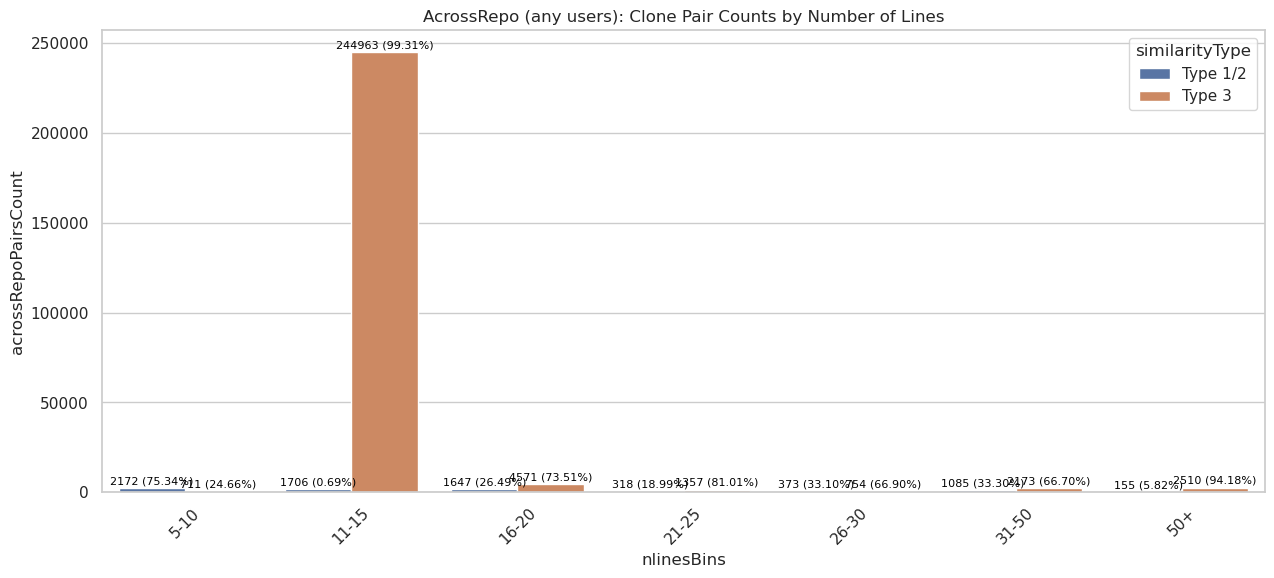

In [25]:
plot_clone_pair_counts(acrossRepo_nlinesSim_df, title="AcrossRepo (any users): Clone Pair Counts by Number of Lines", y_col='acrossRepoPairsCount')

In [26]:
# do the same but let's split acrossRepo_df based on sameUser 
acrossRepo_sameUser_df = acrossRepo_df[acrossRepo_df['sameUser'] == True]
acrossRepo_diffUser_df = acrossRepo_df[acrossRepo_df['sameUser'] == False]

In [27]:
acrossRepo_sameUser_nlinesSim_df = pd.merge(acrossRepo_sameUser_df[['bucketId', 'acrossRepoPairsCount']], buckets_df[['classid', 'similarity', 'nlines']], left_on='bucketId', right_on='classid', how='left').drop_duplicates().reset_index(drop=True)
acrossRepo_sameUser_nlinesSim_df.drop(columns=['classid'], inplace=True)
acrossRepo_sameUser_nlinesSim_df = makeBins(acrossRepo_sameUser_nlinesSim_df, 'nlines')
acrossRepo_sameUser_nlinesSim_df = makeSimilarityTypes(acrossRepo_sameUser_nlinesSim_df, 'similarity', 85)

acrossRepo_sameUser_nlinesSim_df = calculate_clone_percentage(acrossRepo_sameUser_nlinesSim_df, clone_pair_count_col='acrossRepoPairsCount')
acrossRepo_sameUser_nlinesSim_df


/tmp/ipykernel_10370/1586855920.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby([nlines_bins_col, similarity_type_col]).agg({clone_pair_count_col: 'sum'}).reset_index()
/tmp/ipykernel_10370/1586855920.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_clones_per_bin = df.groupby(nlines_bins_col)[clone_pair_count_col].sum().reset_index(name='totalCloneCount')
/tmp/ipykernel_10370/1586855920.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

,nlinesBins,similarityType,acrossRepoPairsCount,percentage
0,5-10,Type 1/2,202,91.402715
2,11-15,Type 1/2,207,25.336597
4,16-20,Type 1/2,292,86.390533
6,21-25,Type 1/2,75,7.324219
8,26-30,Type 1/2,35,42.682927
10,31-50,Type 1/2,218,18.744626
12,50+,Type 1/2,29,4.296296
1,5-10,Type 3,19,8.597285
3,11-15,Type 3,610,74.663403
5,16-20,Type 3,46,13.609467


/home/abeeto/miniconda3/envs/ldaTopicModel/lib/python3.12/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/abeeto/miniconda3/envs/ldaTopicModel/lib/python3.12/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


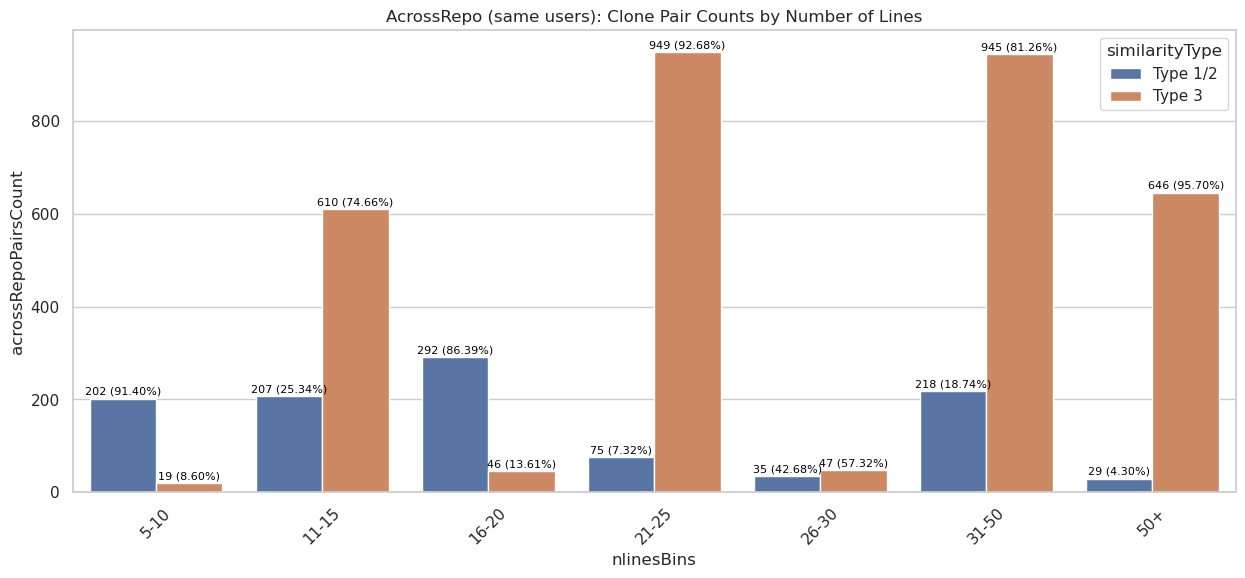

In [28]:
plot_clone_pair_counts(acrossRepo_sameUser_nlinesSim_df, title="AcrossRepo (same users): Clone Pair Counts by Number of Lines", y_col='acrossRepoPairsCount')

In [29]:
acrossRepo_diffUser_nlinesSim_df = pd.merge(acrossRepo_diffUser_df[['bucketId', 'acrossRepoPairsCount']], buckets_df[['classid', 'similarity', 'nlines']], left_on='bucketId', right_on='classid', how='left').drop_duplicates().reset_index(drop=True)
acrossRepo_diffUser_nlinesSim_df.drop(columns=['classid'], inplace=True)
acrossRepo_diffUser_nlinesSim_df = makeBins(acrossRepo_diffUser_nlinesSim_df, 'nlines')
acrossRepo_diffUser_nlinesSim_df = makeSimilarityTypes(acrossRepo_diffUser_nlinesSim_df, 'similarity', 85)

acrossRepo_diffUser_nlinesSim_df = calculate_clone_percentage(acrossRepo_diffUser_nlinesSim_df, clone_pair_count_col='acrossRepoPairsCount')
acrossRepo_diffUser_nlinesSim_df

/tmp/ipykernel_10370/1586855920.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby([nlines_bins_col, similarity_type_col]).agg({clone_pair_count_col: 'sum'}).reset_index()
/tmp/ipykernel_10370/1586855920.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_clones_per_bin = df.groupby(nlines_bins_col)[clone_pair_count_col].sum().reset_index(name='totalCloneCount')
/tmp/ipykernel_10370/1586855920.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

,nlinesBins,similarityType,acrossRepoPairsCount,percentage
0,5-10,Type 1/2,1970,74.004508
2,11-15,Type 1/2,1499,0.609716
4,16-20,Type 1/2,1355,23.044218
6,21-25,Type 1/2,243,37.327189
8,26-30,Type 1/2,338,32.344498
10,31-50,Type 1/2,867,41.384248
12,50+,Type 1/2,126,6.331658
1,5-10,Type 3,692,25.995492
3,11-15,Type 3,244353,99.390284
5,16-20,Type 3,4525,76.955782
